In [21]:
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('default')
import os
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
from matplotlib import cm
import texttable
from xclim import ensembles
import global_land_mask
import logging
from CMIP6_ridgeplot import CMIP6_ridgeplot
import CMIP6_area_calculations
import matplotlib.dates as mdates

logging.getLogger('xclim').setLevel('ERROR')
logging.getLogger('root').setLevel('ERROR')
sns.set(font_scale=1.5, style="whitegrid")

In [22]:
def convert_to_180(ds):
 #   ds=ds.assign_coords(lat=ds.y)
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby('lon')

def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:

        time_objects = ds.indexes['time'].to_datetimeindex() 
        ds=ds.assign_coords({"time": time_objects})                   
        ds = xr.decode_cf(ds)
        
    return ds

def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)
    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)
    #  mask_data[np.isnan(mask_data)] = np.nan

    return xr.DataArray(mask_data, coords={'lat': lat, 'lon': lon},
                        dims=['lat', 'lon'])

def resample_to_monthly(ds:xr.Dataset, var_name):
    ds = xr.where(((ds < 1.e-20) | (ds > 1e20)), np.nan, ds)
    ds = convert_to_180(ds)
    ds = ds.sel(time=slice(start_time,end_time))

    ds_lme = convert_time(ds)
    # Add land mask
    ds_lme["mask"] = create_land_ocean_mask(ds_lme)
    ds_lme = ds_lme.where(ds_lme.mask == 1)
    ds_lme = get_data_within_LME(ds_lme, var_name, LME, False)
    return ds_lme.resample(time="M").mean()

def get_area_averaged_ds(fname_perc, fname_stats,  scenario, var_name, LME):

    var_name_mean = f"{var_name}_mean"

    if os.path.exists(fname_stats) and os.path.exists(fname_perc):
        ds_stats = xr.open_dataset(fname_stats)
        ds_perc = xr.open_dataset(fname_perc)

        ds_stats = resample_to_monthly(ds_stats, var_name_mean)
        ds_perc = resample_to_monthly(ds_perc, var_name)

        # First we calculate the total area covered by the LME. The total areacello is
        # broadcasted along time axis and used later.
        ds_perc["areacello"] = CMIP6_area_calculations.calculate_areacello(ds_perc.sel(percentiles=2.5), var_name)
        total_area_lme = np.nansum(ds_perc["areacello"])

        print("[calculate_areacello] Average total area {:,.2f} km2".format(total_area_lme))
        ds_stats = get_data_within_LME(ds_stats, var_name_mean, LME, False)

        # Average data spatially within the LME as a function of time
        ds_s = ds_stats.mean({"lat","lon"}, skipna=True)
        ds_s = ds_s.assign(std = ds_stats[f"{var_name}_stdev"].mean(dim={"lat","lon"}))

        df_s = ds_s.to_dataframe().dropna()
        df_s = df_s.reset_index()

        # Calculate the 5 year rolling mean to avoid outliers and extremes
        # and get the trend.
        roll_years=5

        df_s=df_s.resample("A", on="time").mean()
        df_s["roll_mean"]=df_s[var_name_mean].rolling(roll_years).mean()
        df_s["roll_std"]=df_s[f"{var_name}_stdev"].rolling(roll_years).mean()
        df_s["model_scenario"]=scenario

        # Save to CSV file
        df_s.to_csv(f"test_{LME}.csv")

        model_info={}
        model_info["model_name"]="ensemble"
        model_info["model_scenario"]=scenario
        model_info["model_var"]=var_name
        formatter="{:.2f}"
        model_info["model_min"]=formatter.format(np.nanmin(df_s[var_name_mean]))
        model_info["model_max"]=formatter.format(np.nanmax(df_s[var_name_mean]))
        return df_s, ds_stats, total_area_lme
    else:
        return None, None

In [23]:
def get_LME_records():
    lme_file='../oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def get_LME_records_plot():
    lme_file='../oceanography/Shapefiles/LME66_180/LME66_180.shp'
    return gpd.read_file(lme_file)

def create_colors(N):
    color=iter(cm.tab20b(np.linspace(0,1,N)))
    return [next(color) for c in range(N)]


def get_data_within_LME(ds,var_name,LME,create_maps):
    print("Working on LME: {}".format(LME))

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
   # for name in shdf['LME_NAME']:
   #     print(name)
    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.
    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function
    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'}) #.to_dataset()

    return clipped

[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Barents Sea
[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Barents Sea
[calculate_areacello] Average total area 4,511,293.93 km2
Working on LME: Barents Sea
[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Barents Sea
[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Barents Sea
[calculate_areacello] Average total area 4,511,293.93 km2
Working on LME: Barents Sea
Created figure Figures/CMIP6_light_uv_Barents Sea.png
[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Northern Bering - Chukchi Seas
[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Northern Bering - Chukchi Seas
[calculate_areacello] Average total area 27,260,122.62 km2
Working on LME: Northern Bering - Chukchi Seas
[create_land_ocean_mask] Running create_land_ocean_mask
Working on LME: Northern Bering - Chukchi Seas
[create_land_ocean_mask

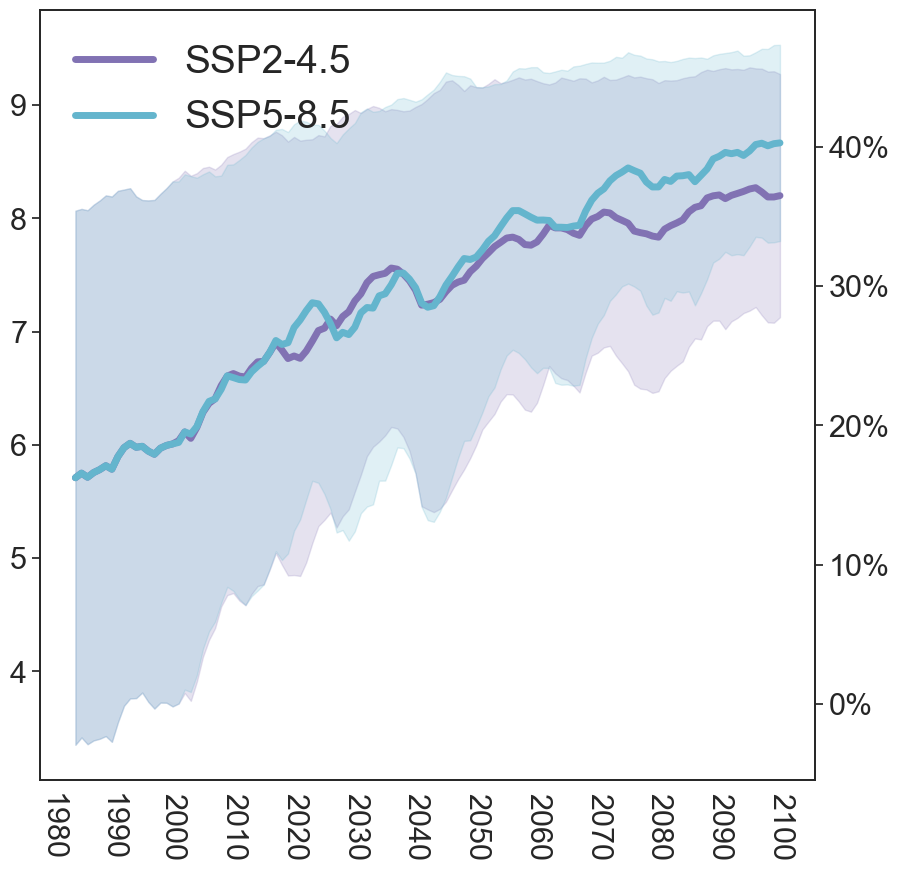

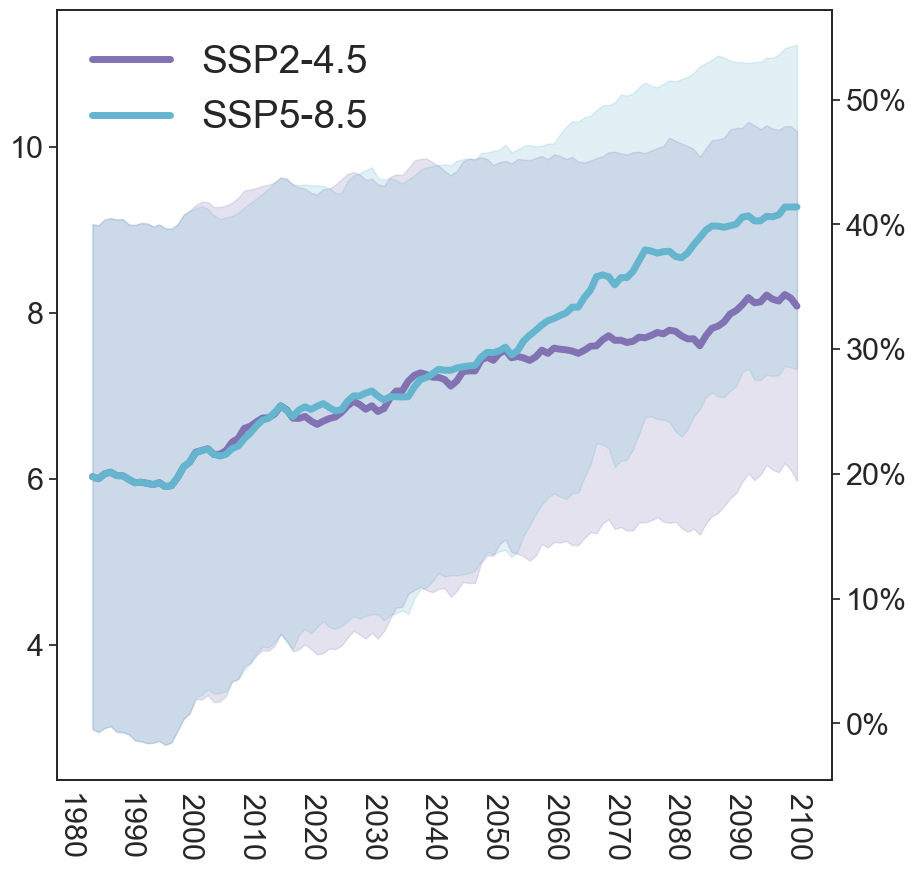

In [24]:
scenarios = ["ssp245", "ssp585"]
member_range = 12
frequency = "A"
period = "1979-01-01-2099-12-16"
start_time = "1979-01-01"
end_time = "2099-12-16"

models = ["ensemble"]
ds_var_names = ["uv"] #, "uvb", "uv"]
#ds_var_names = ["uv","uvb"]  #,"uv"]
write_stats_to_file = False
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)


LMES = ['California Current', 'East Bering Sea', 'Gulf of Alaska',
        'Northern Bering - Chukchi Seas', 'West Bering Sea', 'Sea of Japan',
        'Oyashio Current', 'Kuroshio Current', 'East China Sea',
        'South China Sea', 'Sea of Okhotsk', 'Yellow Sea',
        'Aleutian Islands']

LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']
#LMES = ['Barents Sea']

for var_name in ds_var_names:
    for LME in LMES:
        create_maps = False
        saved_total_area_lme = None

        f = plt.figure(figsize=(10, 10))
        gs = f.add_gridspec(1, 1)
        ax = f.add_subplot(gs[0, 0])
        sns.set_palette("tab10")
        loop=0
      #  palette_tab10 = sns.color_palette("tab10", 10)
      #  colors = [palette_tab10[0], palette_tab10[1], palette_tab10[3]]


        # Colors from deep default seaborn palette found here:
        # https://github.com/mwaskom/seaborn/blob/master/seaborn/palettes.py
        colors_water = ["#8172B3", "#64B5CD"]

        # We loop over all of the scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:

            fname_perc = f"../oceanography/light/ncfiles/ensemble/{var_name}_ensemble_perc_{scenario}.nc"
            fname_stats = f"../oceanography/light/ncfiles/ensemble/{var_name}_ensemble_stats_{scenario}.nc"

            if scenario=="ssp585":
                label="SSP5-8.5"
            else:
                label="SSP2-4.5"

            df_s,ds_stats, total_area_lme = get_area_averaged_ds(fname_perc, fname_stats, scenario, var_name, LME)

            if df_s is not None:
                saved_total_area_lme = total_area_lme

            outfile = "Figures/{}_ensemble_{}_{}.png".format(var_name.capitalize(), scenario, LME)
         #   CMIP6_ridgeplot.ridgeplot("{}_mean".format(var_name),
         #                             None, outfile,
         #                                     glorys=False, depth_threshold=None,
         #                                     ds=ds_stats)

            clim = (df_s["roll_mean"].loc['1980-01-01':'2000-01-01']).mean()
            df_s["rel_change"] = ((df_s["roll_mean"] - float(clim)) / float(clim)) * 100.

            ax.fill_between(df_s["roll_mean"].index,
                df_s["roll_mean"]-df_s["roll_std"],
                            df_s["roll_mean"]+df_s["roll_std"],
                alpha=0.2,
                color=colors_water[loop],
                label=None,
            )

            ax.plot(
                df_s["roll_mean"].index,
                df_s["roll_mean"],
                linewidth=5,
                color=colors_water[loop],
                label=f"{label}",
            )

            ax.tick_params(labelsize=22)
            ax.set_xlabel("", fontsize=20)
            ax.set_ylabel("", fontsize=20)

            if loop==0:
                ax2 = ax.twinx()

            ax2.plot(
                df_s["rel_change"].index,
                df_s["rel_change"],
                linewidth=0,
                linestyle="--",
                color=colors_water[loop],
                label=None,
            )

            ax2.tick_params(labelsize=22)
            ax2.set_xlabel("", fontsize=20)
            ax2.set_ylabel("", fontsize=20)
            ylabels = ['{:,.0%}'.format(y) for y in ax2.get_yticks() / 100.]
            ax2.set_yticklabels(ylabels)
            import matplotlib.dates as mdates
            ax.xaxis.set_major_locator(mdates.YearLocator(base=10))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=-90)
            ax.legend(loc="upper left", frameon=False, fontsize=28)

            if not os.path.exists("Figures"):
                os.makedirs("Figures")

            if loop==1:
                plotfile = "Figures/CMIP6_light_{}_{}.png".format(var_name, LME)
                print("Created figure {}".format(plotfile))
                plt.savefig(plotfile, dpi=300,
                            bbox_inches='tight')

            loop+=1